# Combining DMD models

The purpose of this notebook is to show that you can apply separate DMD models to subsamples (in this case, in the time dimension) of a dataset, and then combine the results to get an accurate forecast. This is useful when the dataset you want to apply DMD to is too large to fit into memory all at once.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
from matplotlib import pyplot as plt
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator, sample_data

Generate the synthetic data using the `SignalGenerator` class.

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=80)
signal_generator.add_sinusoid1(a=2, omega=0.5, k=1.5)
signal_generator.add_sinusoid2(a=3, omega=2.5, c=1.5, k=0.5)
signal_generator.add_sinusoid2(a=3, omega=5, c=-1.5, k=0.5)
signal_generator.add_noise(random_seed=42)

Plot the sinusoids that compose the signal and the signal itself.

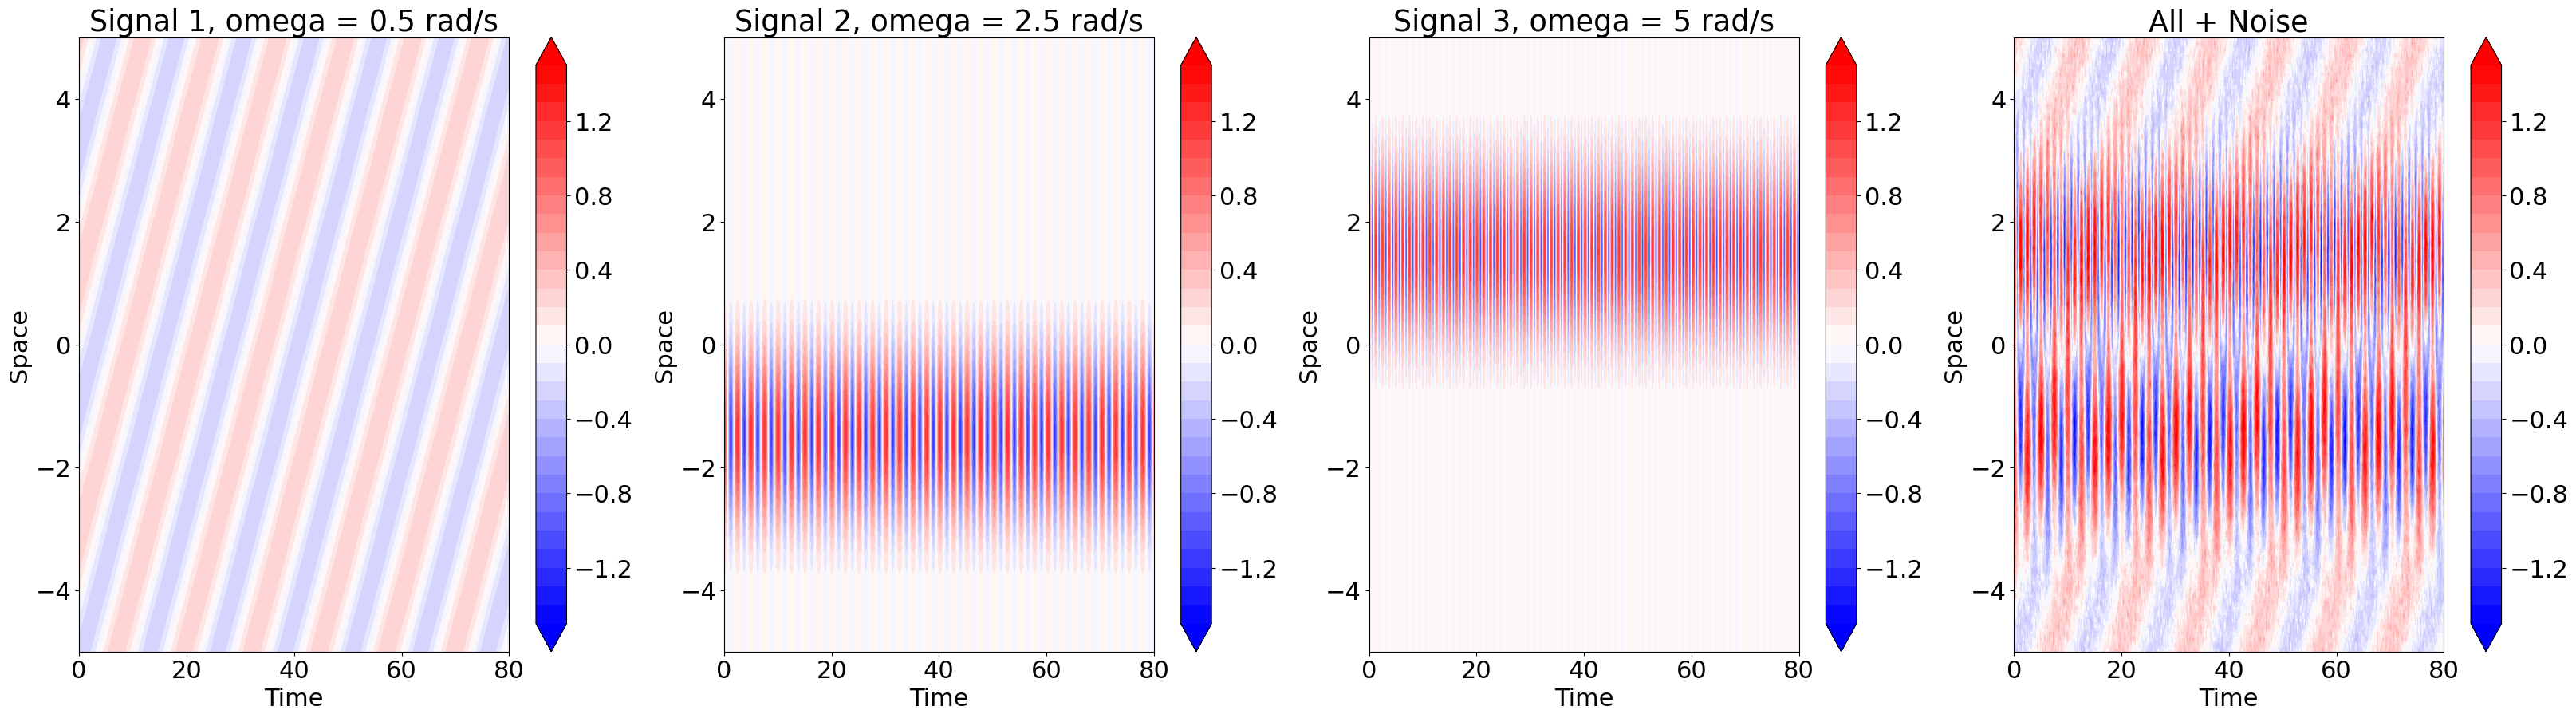

In [3]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 4, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 3)
contour = ax.contourf(
    signal_generator.T, signal_generator.X, signal_generator.components[2]["signal"], levels=levels, cmap='bwr', extend='both'
    )
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, omega = {signal_generator.components[2]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

Split the data into training and test sets.

In [4]:
train_frac = 0.8  # Fraction of data used for training
signal_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
signal_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

In [5]:
print(f"Training data shape: {signal_train.shape}")

Training data shape: (400, 100)


Sample the training set over time at different sampling rates, and over different sampling periods. We will then separately apply DMD to each of these subsamples.

In [6]:
fast_data, t_fast = sample_data(signal_train, t_train, dt=1, duration=100)
medium_data, t_medium = sample_data(signal_train, t_train, dt=2, duration=200)
slow_data, t_slow = sample_data(signal_train, t_train, dt=5)

In [7]:
print(f"Fast-sampled data shape: {fast_data.shape}")
print(f"Medium-sampled data shape: {medium_data.shape}")
print(f"Slow-sampled data shape: {slow_data.shape}")

Fast-sampled data shape: (100, 100)
Medium-sampled data shape: (100, 100)
Slow-sampled data shape: (80, 100)


In [8]:
# print info about the time sampling
# note that time here doesn't have a particular unit
print("Slow-sampled data:")
print(f"Start time: {np.round(t_slow[0], 2)}, end time: {np.round(t_slow[-1], 2)}, time delta: {np.round(t_slow[1] - t_slow[0], 2)}")
print(f"Medium-sampled data:")
print(f"Start time: {np.round(t_medium[0], 2)}, end time: {np.round(t_medium[-1], 2)}, time delta: {np.round(t_medium[1] - t_medium[0], 2)}")
print(f"Fast-sampled data:")
print(f"Start time: {np.round(t_fast[0], 2)}, end time: {np.round(t_fast[-1], 2)}, time delta: {np.round(t_fast[1] - t_fast[0], 2)}")

Slow-sampled data:
Start time: 0.0, end time: 63.33, time delta: 0.8
Medium-sampled data:
Start time: 32.06, end time: 63.81, time delta: 0.32
Fast-sampled data:
Start time: 48.1, end time: 63.97, time delta: 0.16


Plot the subsamples (note that the time axis is different for each subsample).

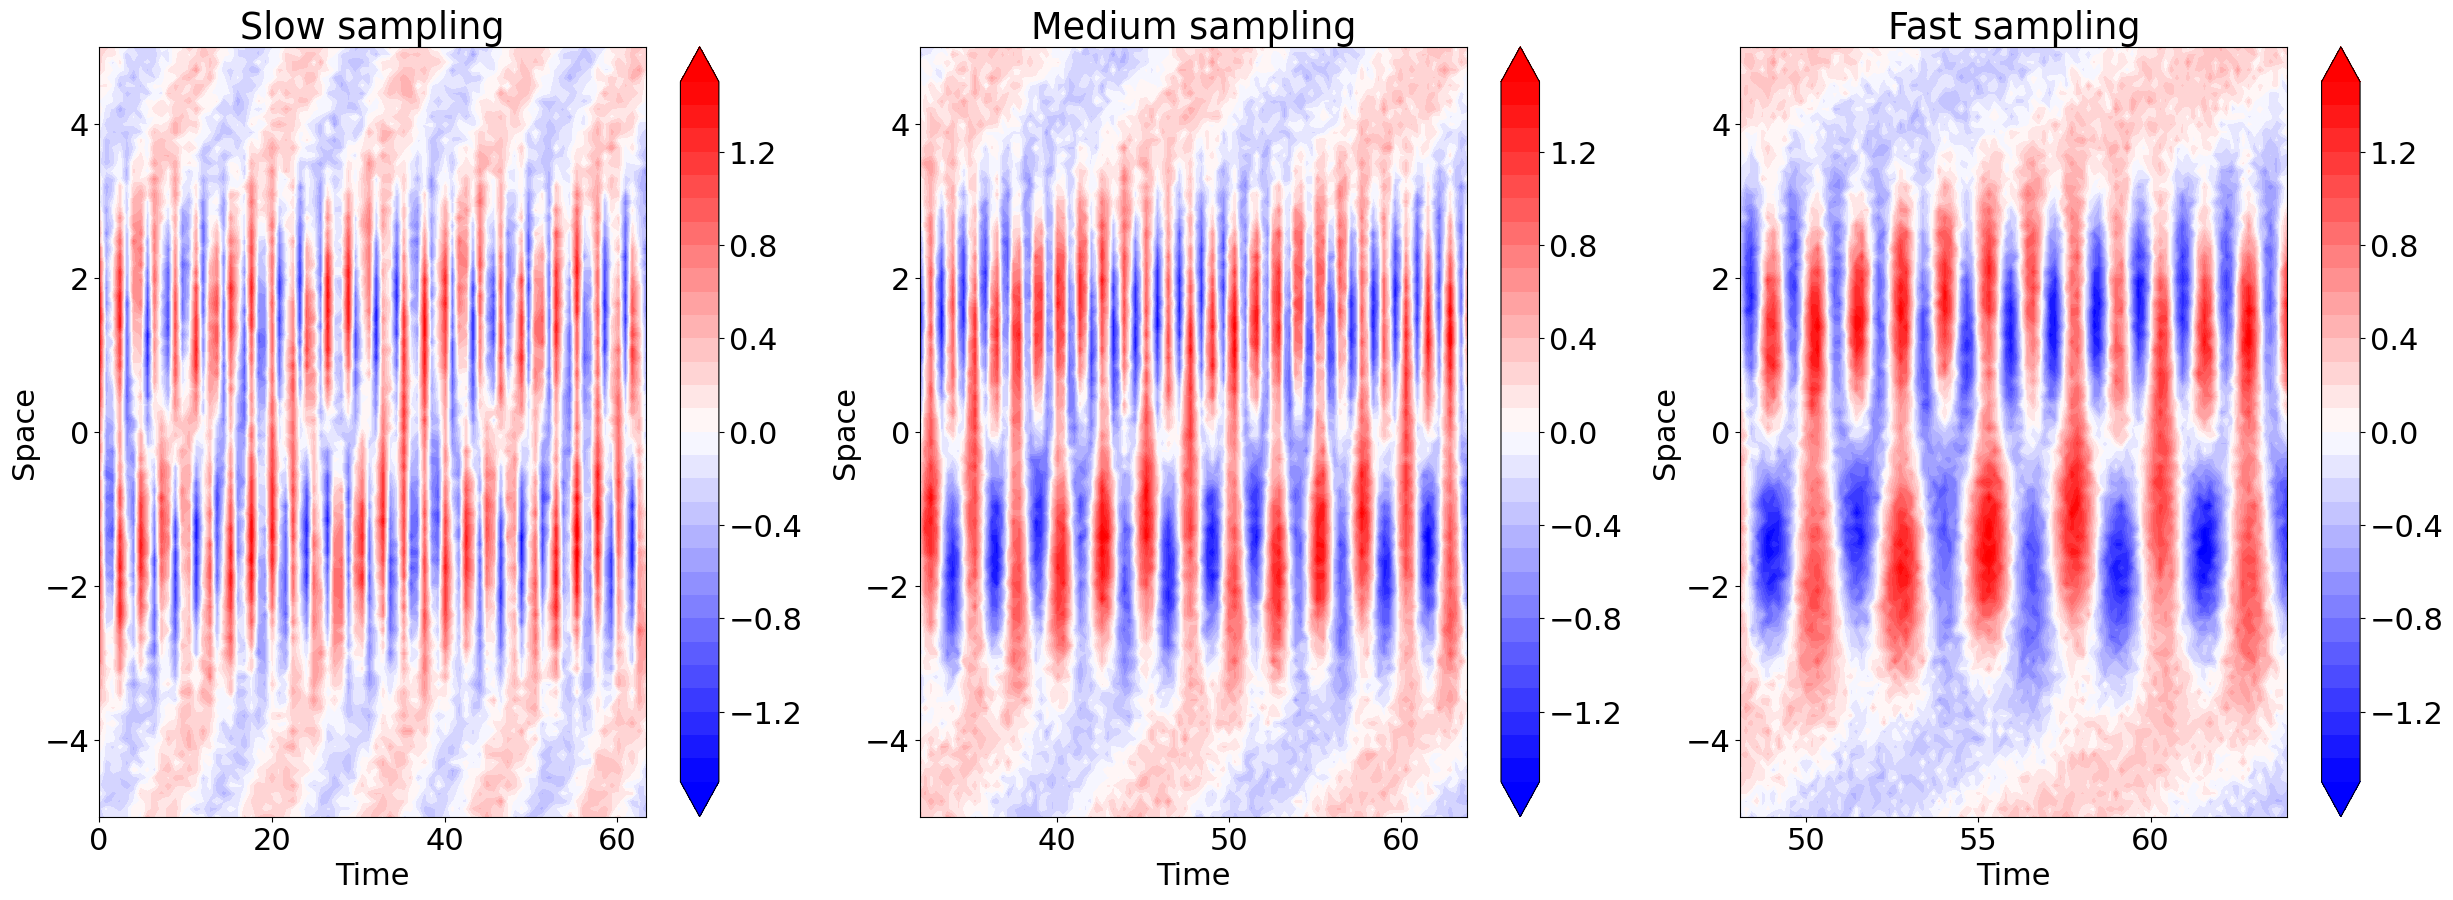

In [9]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(30, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
T, X = np.meshgrid(t_slow, signal_generator.x)
contour = ax.contourf(T, X, slow_data.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Slow sampling')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
T, X = np.meshgrid(t_medium, signal_generator.x)
contour = ax.contourf(T, X, medium_data.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Medium sampling')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
T, X = np.meshgrid(t_fast, signal_generator.x)
contour = ax.contourf(T, X, fast_data.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Fast sampling')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Apply DMD to the three subsamples

Here we will use Algorithm 3 of Askham & Kutz (2018).

In [10]:
svd_rank = 6  # we have 3 sinusoids, so we need 6 DMD modes
delay = 2  # apply time delay embedding

### DMD model on data sampled at slow-rate

In [11]:
optdmd_slow = BOPDMD(
    svd_rank=svd_rank,
    num_trials=0,
    use_proj=True,
    varpro_opts_dict={"verbose": True}
    )
delay_optdmd_slow = hankel_preprocessing(optdmd_slow, d=delay)

In [12]:
t_delay_slow = t_slow[:-delay+1]
delay_optdmd_slow.fit(slow_data.T, t=t_delay_slow)

Step 1 Error 0.6546091824944759 Lambda 0.3333333333333333
Step 2 Error 0.6537967293117745 Lambda 0.1111111111111111
Step 3 Error 0.6531253757115144 Lambda 0.037037037037037035
Step 4 Error 0.6523987189351147 Lambda 0.012345679012345678
Step 5 Error 0.6514963943053586 Lambda 0.004115226337448559
Step 6 Error 0.6500614662541674 Lambda 0.001371742112482853
Step 7 Error 0.6438789142910029 Lambda 0.0004572473708276176
Step 8 Error 0.63566864671389 Lambda 7.491540923639687
Step 9 Error 0.6235413364458481 Lambda 2.4971803078798955
Step 10 Error 0.49682942624207516 Lambda 0.8323934359599652
Step 11 Error 0.43482359083644834 Lambda 0.2774644786533217
Step 12 Error 0.4048420139803544 Lambda 0.09248815955110723
Step 13 Error 0.30760594836765265 Lambda 0.03082938651703574
Step 14 Error 0.11124563636529833 Lambda 0.010276462172345246
Step 15 Error 0.032842195574960334 Lambda 0.0034254873907817486
Step 16 Error 0.032827064434759794 Lambda 0.0011418291302605827
Step 17 Error 0.032827064221325045 Lamb

Plot a summary of the results

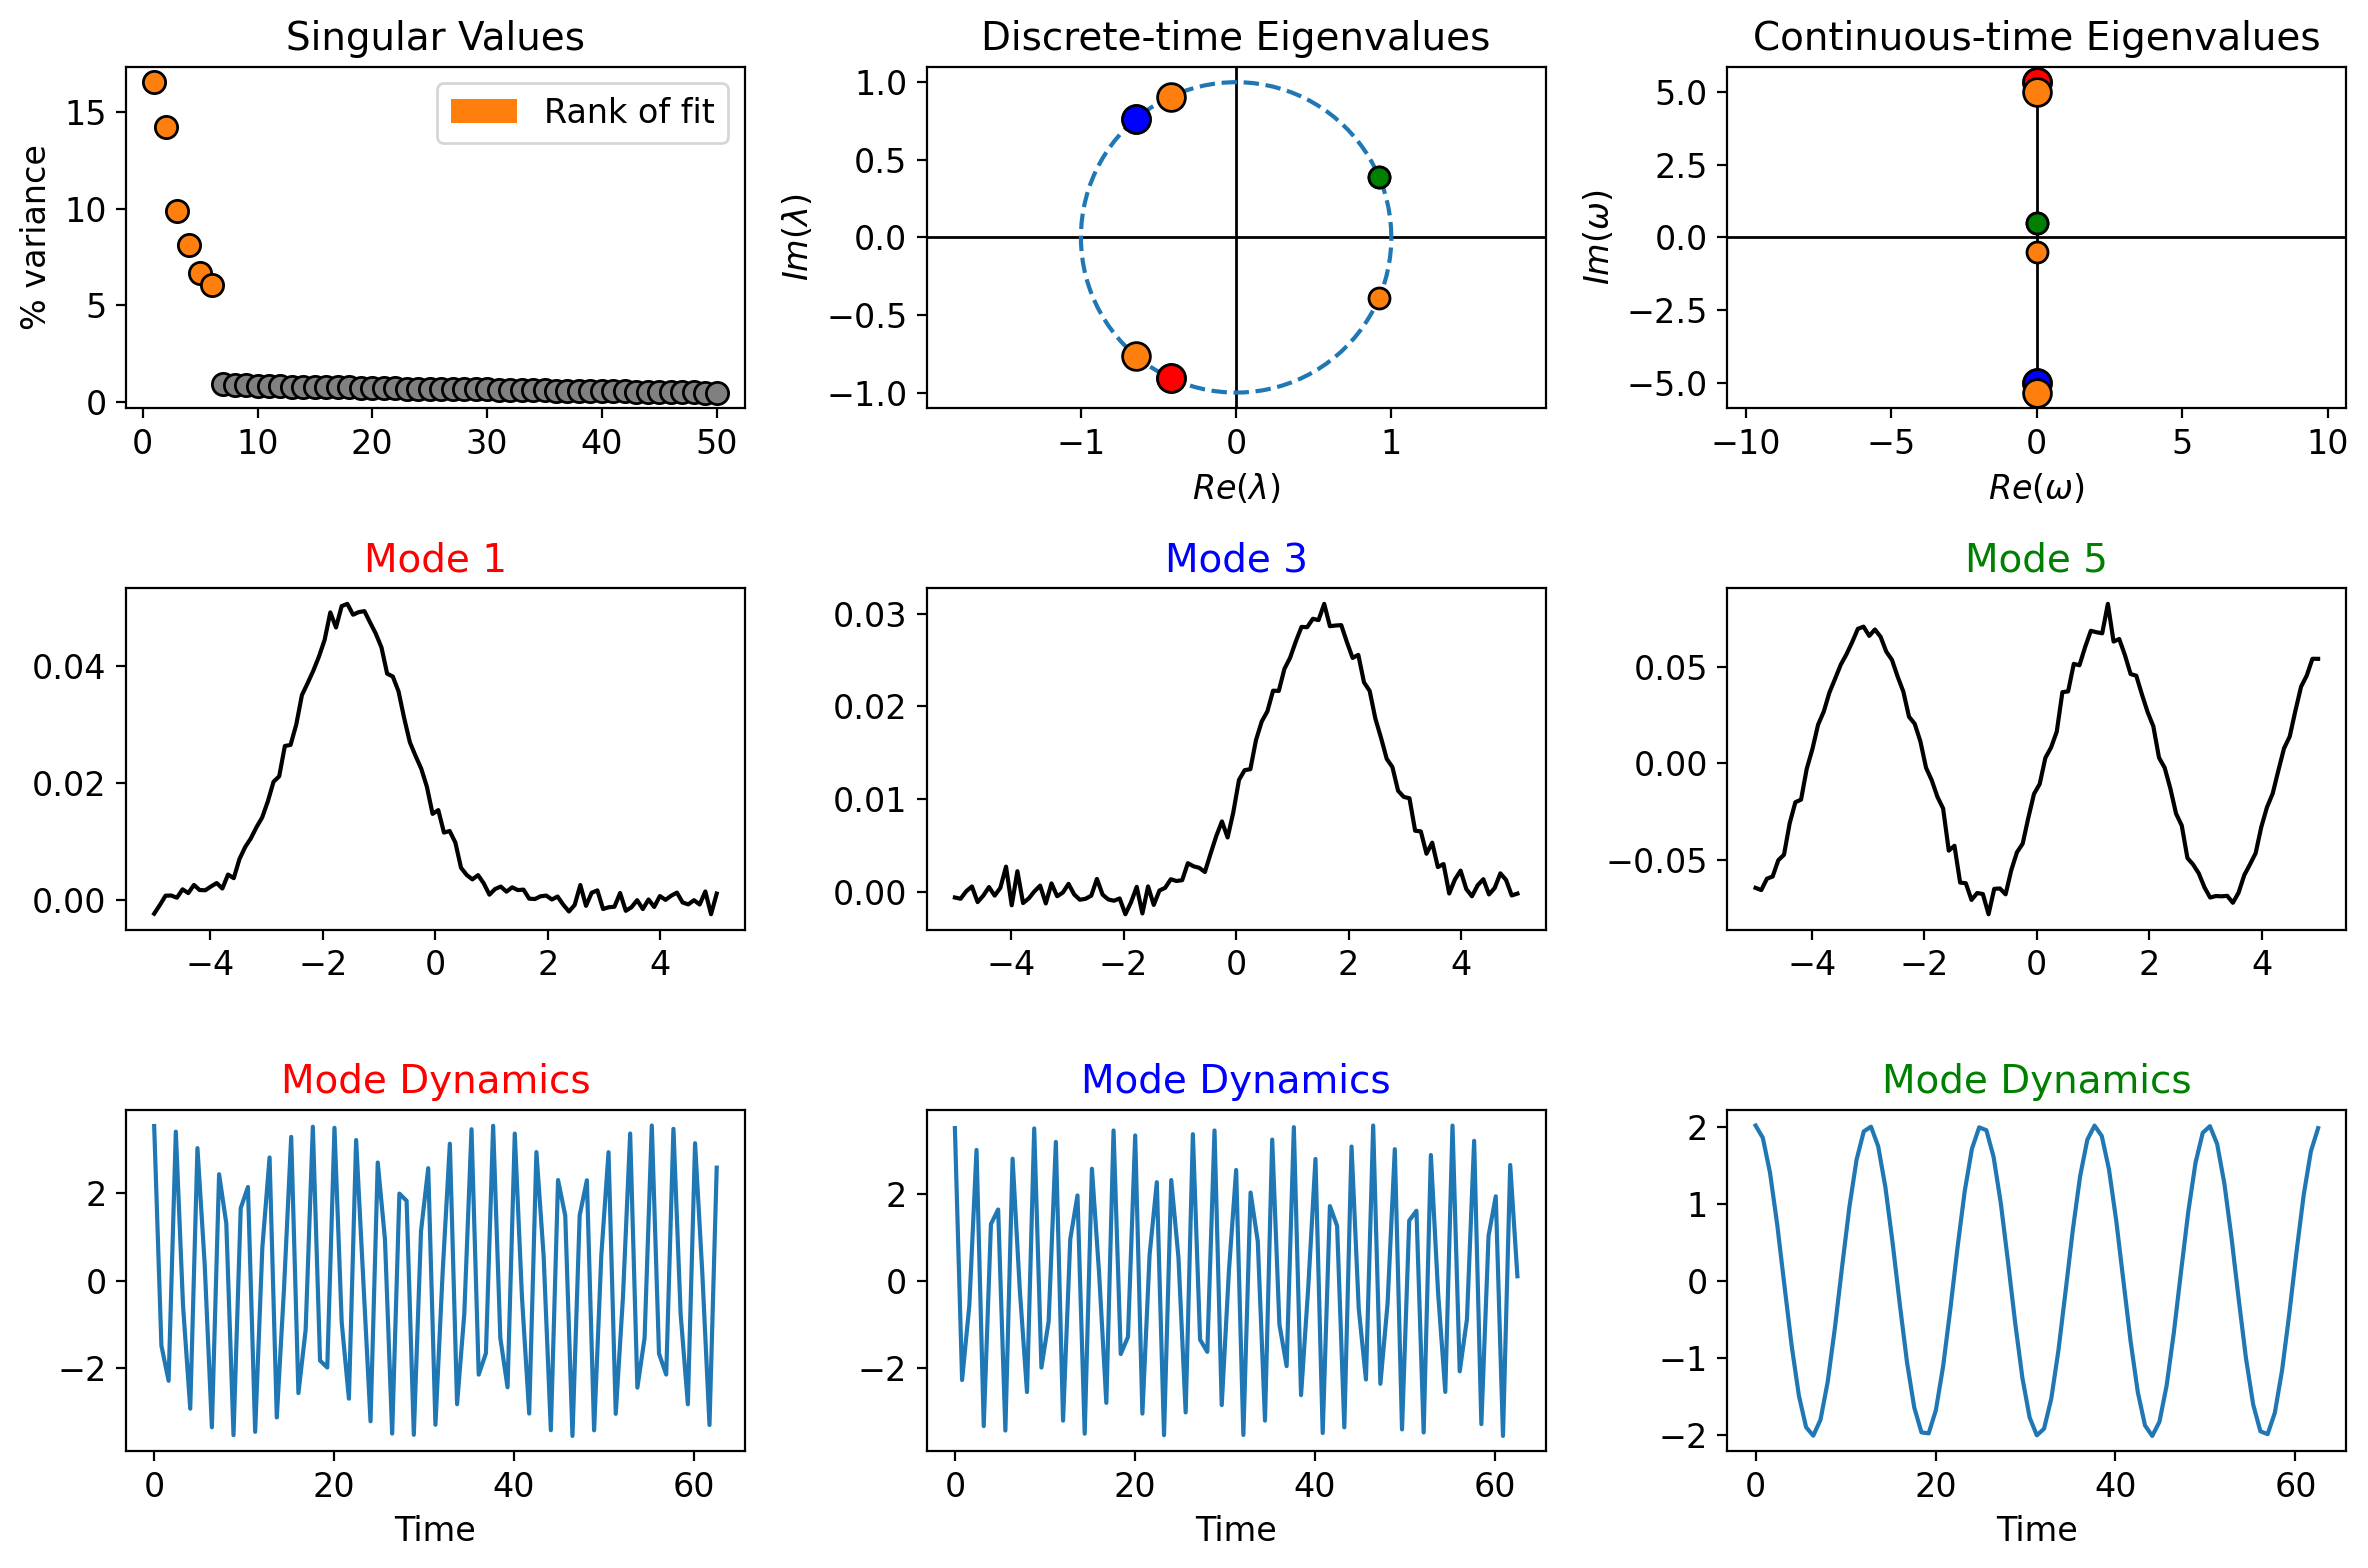

In [13]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd_slow, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

Sort the modes by amplitude and print the amplitudes and eigenvalues.

In [14]:
sorted_index_slow = np.argsort(delay_optdmd_slow.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd_slow.amplitudes[sorted_index_slow]}")
print(f"Eigenvalues: {delay_optdmd_slow.eigs[sorted_index_slow]}")

Amplitudes: [3.52308874 3.52308874 3.51368413 3.51368413 2.01368937 2.01368937]
Eigenvalues: [8.96558775e-05+5.33811092j 8.96558833e-05-5.33811092j
 3.58803922e-04-4.99989334j 3.58803925e-04+4.99989334j
 4.80142561e-07+0.49950151j 4.80145203e-07-0.49950151j]


### DMD model on data sampled at medium-rate

In [15]:
optdmd_medium = BOPDMD(
    svd_rank=svd_rank,
    num_trials=0,
    use_proj=True,
    varpro_opts_dict={
        "verbose": True,
        "lamup": 2.5,
        }
    )
delay_optdmd_medium = hankel_preprocessing(optdmd_medium, d=delay)

In [16]:
t_delay_medium = t_medium[:-delay+1]
delay_optdmd_medium.fit(medium_data.T, t=t_delay_medium)

Step 1 Error 0.840004690047623 Lambda 0.3333333333333333
Step 2 Error 0.7169072906141629 Lambda 0.1111111111111111
Step 3 Error 0.6585036368673737 Lambda 0.037037037037037035
Step 4 Error 0.6565223341673164 Lambda 0.012345679012345678
Step 5 Error 0.6551897533555809 Lambda 0.004115226337448559
Step 6 Error 0.6525376951549562 Lambda 0.001371742112482853
Step 7 Error 0.6474130829123128 Lambda 0.0004572473708276176
Step 8 Error 0.6473638065225396 Lambda 68.13516778165364
Step 9 Error 0.6473143066219289 Lambda 22.711722593884545
Step 10 Error 0.6473030761416724 Lambda 141.94826621177842
Step 11 Error 0.647291140860603 Lambda 47.31608873725947
Step 12 Error 0.6472909313014928 Lambda 739.3138865196793
Step 13 Error 0.6472900650050365 Lambda 246.43796217322642
Step 14 Error 0.6472867271888604 Lambda 82.14598739107547
Step 15 Error 0.647285347960446 Lambda 513.4124211942217
Step 16 Error 0.6472845221252911 Lambda 171.13747373140723
Step 17 Error 0.6472843755383585 Lambda 2674.023027053238
Fail

Note that in this case the error does not decrease as much as in the previous case during algorithm iteration, even by increasing the `lamup` parameter.

Plot a summary of the results

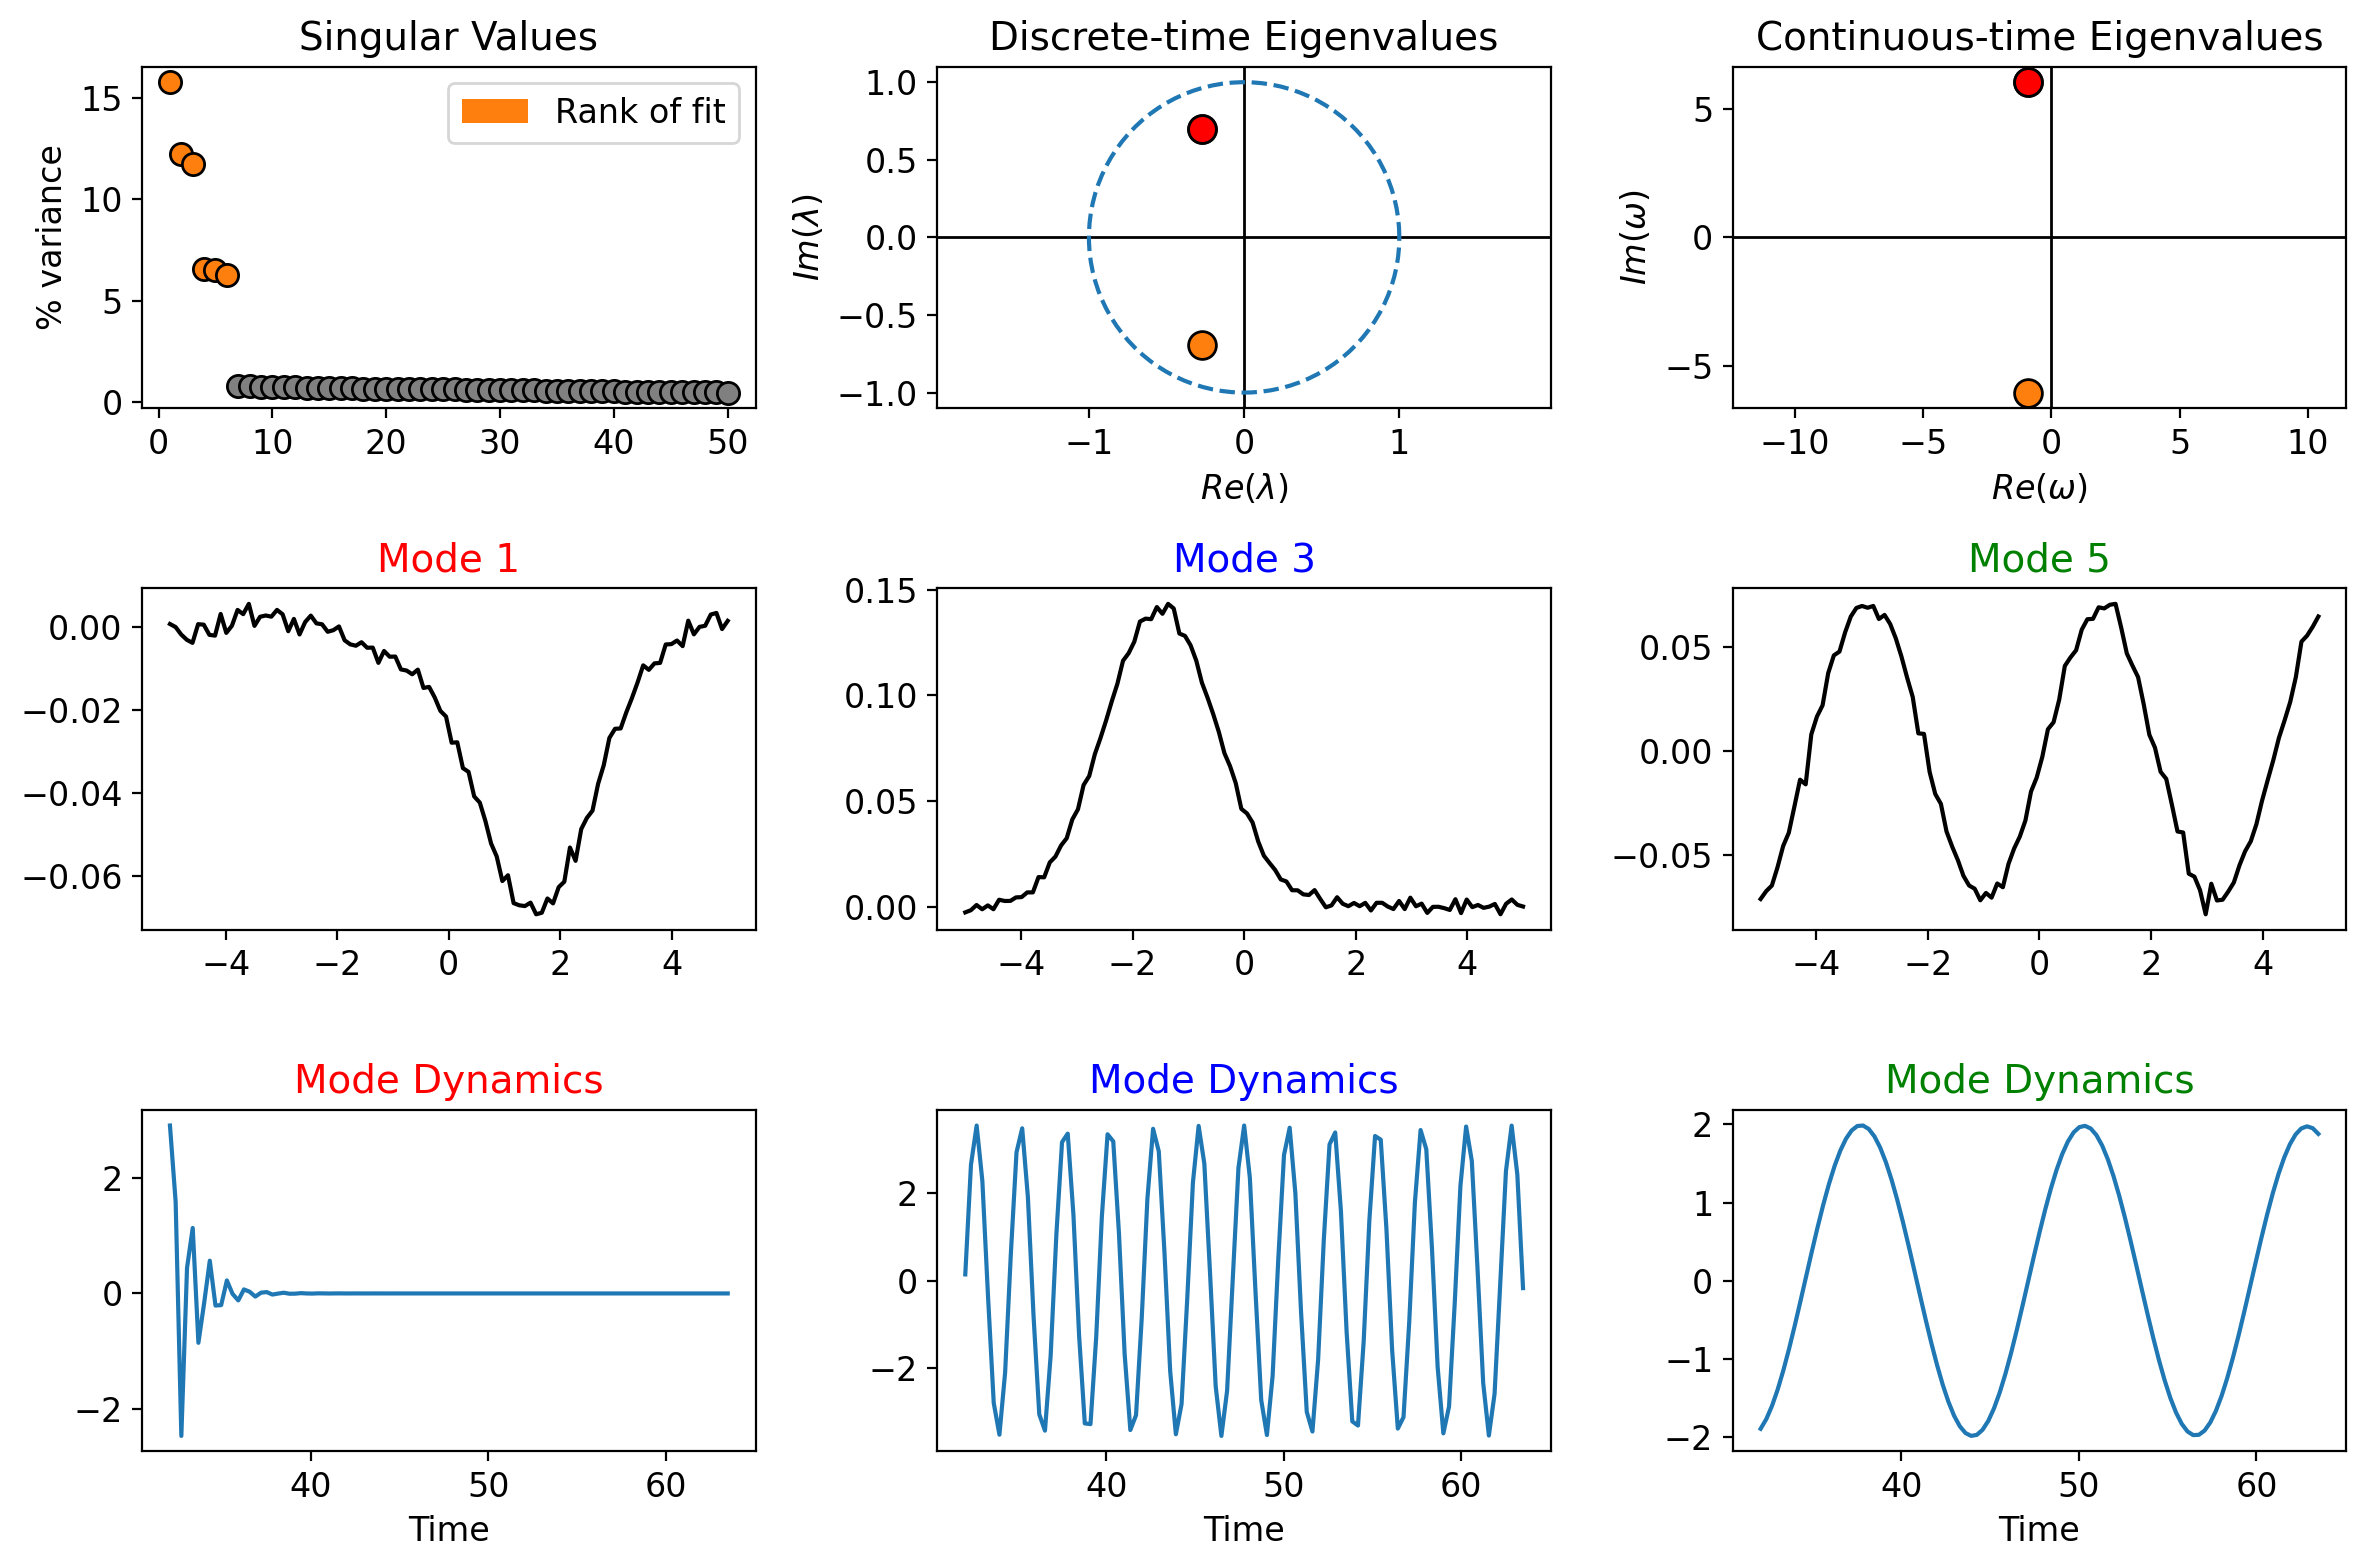

In [17]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd_medium, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

Sort the modes by amplitude and print the amplitudes and eigenvalues.

In [18]:
sorted_index_medium = np.argsort(delay_optdmd_medium.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd_medium.amplitudes[sorted_index_medium]}")
print(f"Eigenvalues: {delay_optdmd_medium.eigs[sorted_index_medium]}")

Amplitudes: [2.52487538e+13 2.52408114e+13 3.57181076e+00 3.57156285e+00
 2.01066502e+00 2.01021955e+00]
Eigenvalues: [-9.15753784e-01+6.04773103j -9.15749959e-01-6.04771929j
 -9.41805363e-05+2.49970323j -9.49634736e-05-2.49970339j
 -2.83293932e-04+0.4997864j  -2.83065886e-04-0.49978425j]


In this case optimized DMD does not do a good job at capturing the dynamics of the fastest mode. However, here we are interested in capturing the dynamics of the medium speed mode, which is well captured.

### DMD model on data sampled at fast-rate

In [19]:
optdmd_fast = BOPDMD(
    svd_rank=svd_rank,
    num_trials=0,
    use_proj=True,
    varpro_opts_dict={
        "verbose": True,
        }
    )
delay_optdmd_fast = hankel_preprocessing(optdmd_fast, d=delay)

In [20]:
t_delay_fast = t_fast[:-delay+1]
delay_optdmd_fast.fit(fast_data.T, t=t_delay_fast)

Step 1 Error 0.525659147078793 Lambda 0.3333333333333333
Step 2 Error 0.29265531813927065 Lambda 0.1111111111111111
Step 3 Error 0.0558677095586302 Lambda 0.037037037037037035
Step 4 Error 0.03309372487068353 Lambda 0.012345679012345678
Step 5 Error 0.03309193242521377 Lambda 0.004115226337448559
Step 6 Error 0.03309193237483356 Lambda 0.001371742112482853
Step 7 Error 0.033091932374832475 Lambda 0.0011655296718797782
Stall detected: error reduced by less than 1e-12 times the error at the previous step. Iteration 7. Current error 0.033091932374832475. Consider increasing tol or decreasing eps_stall.


Plot a summary of the results

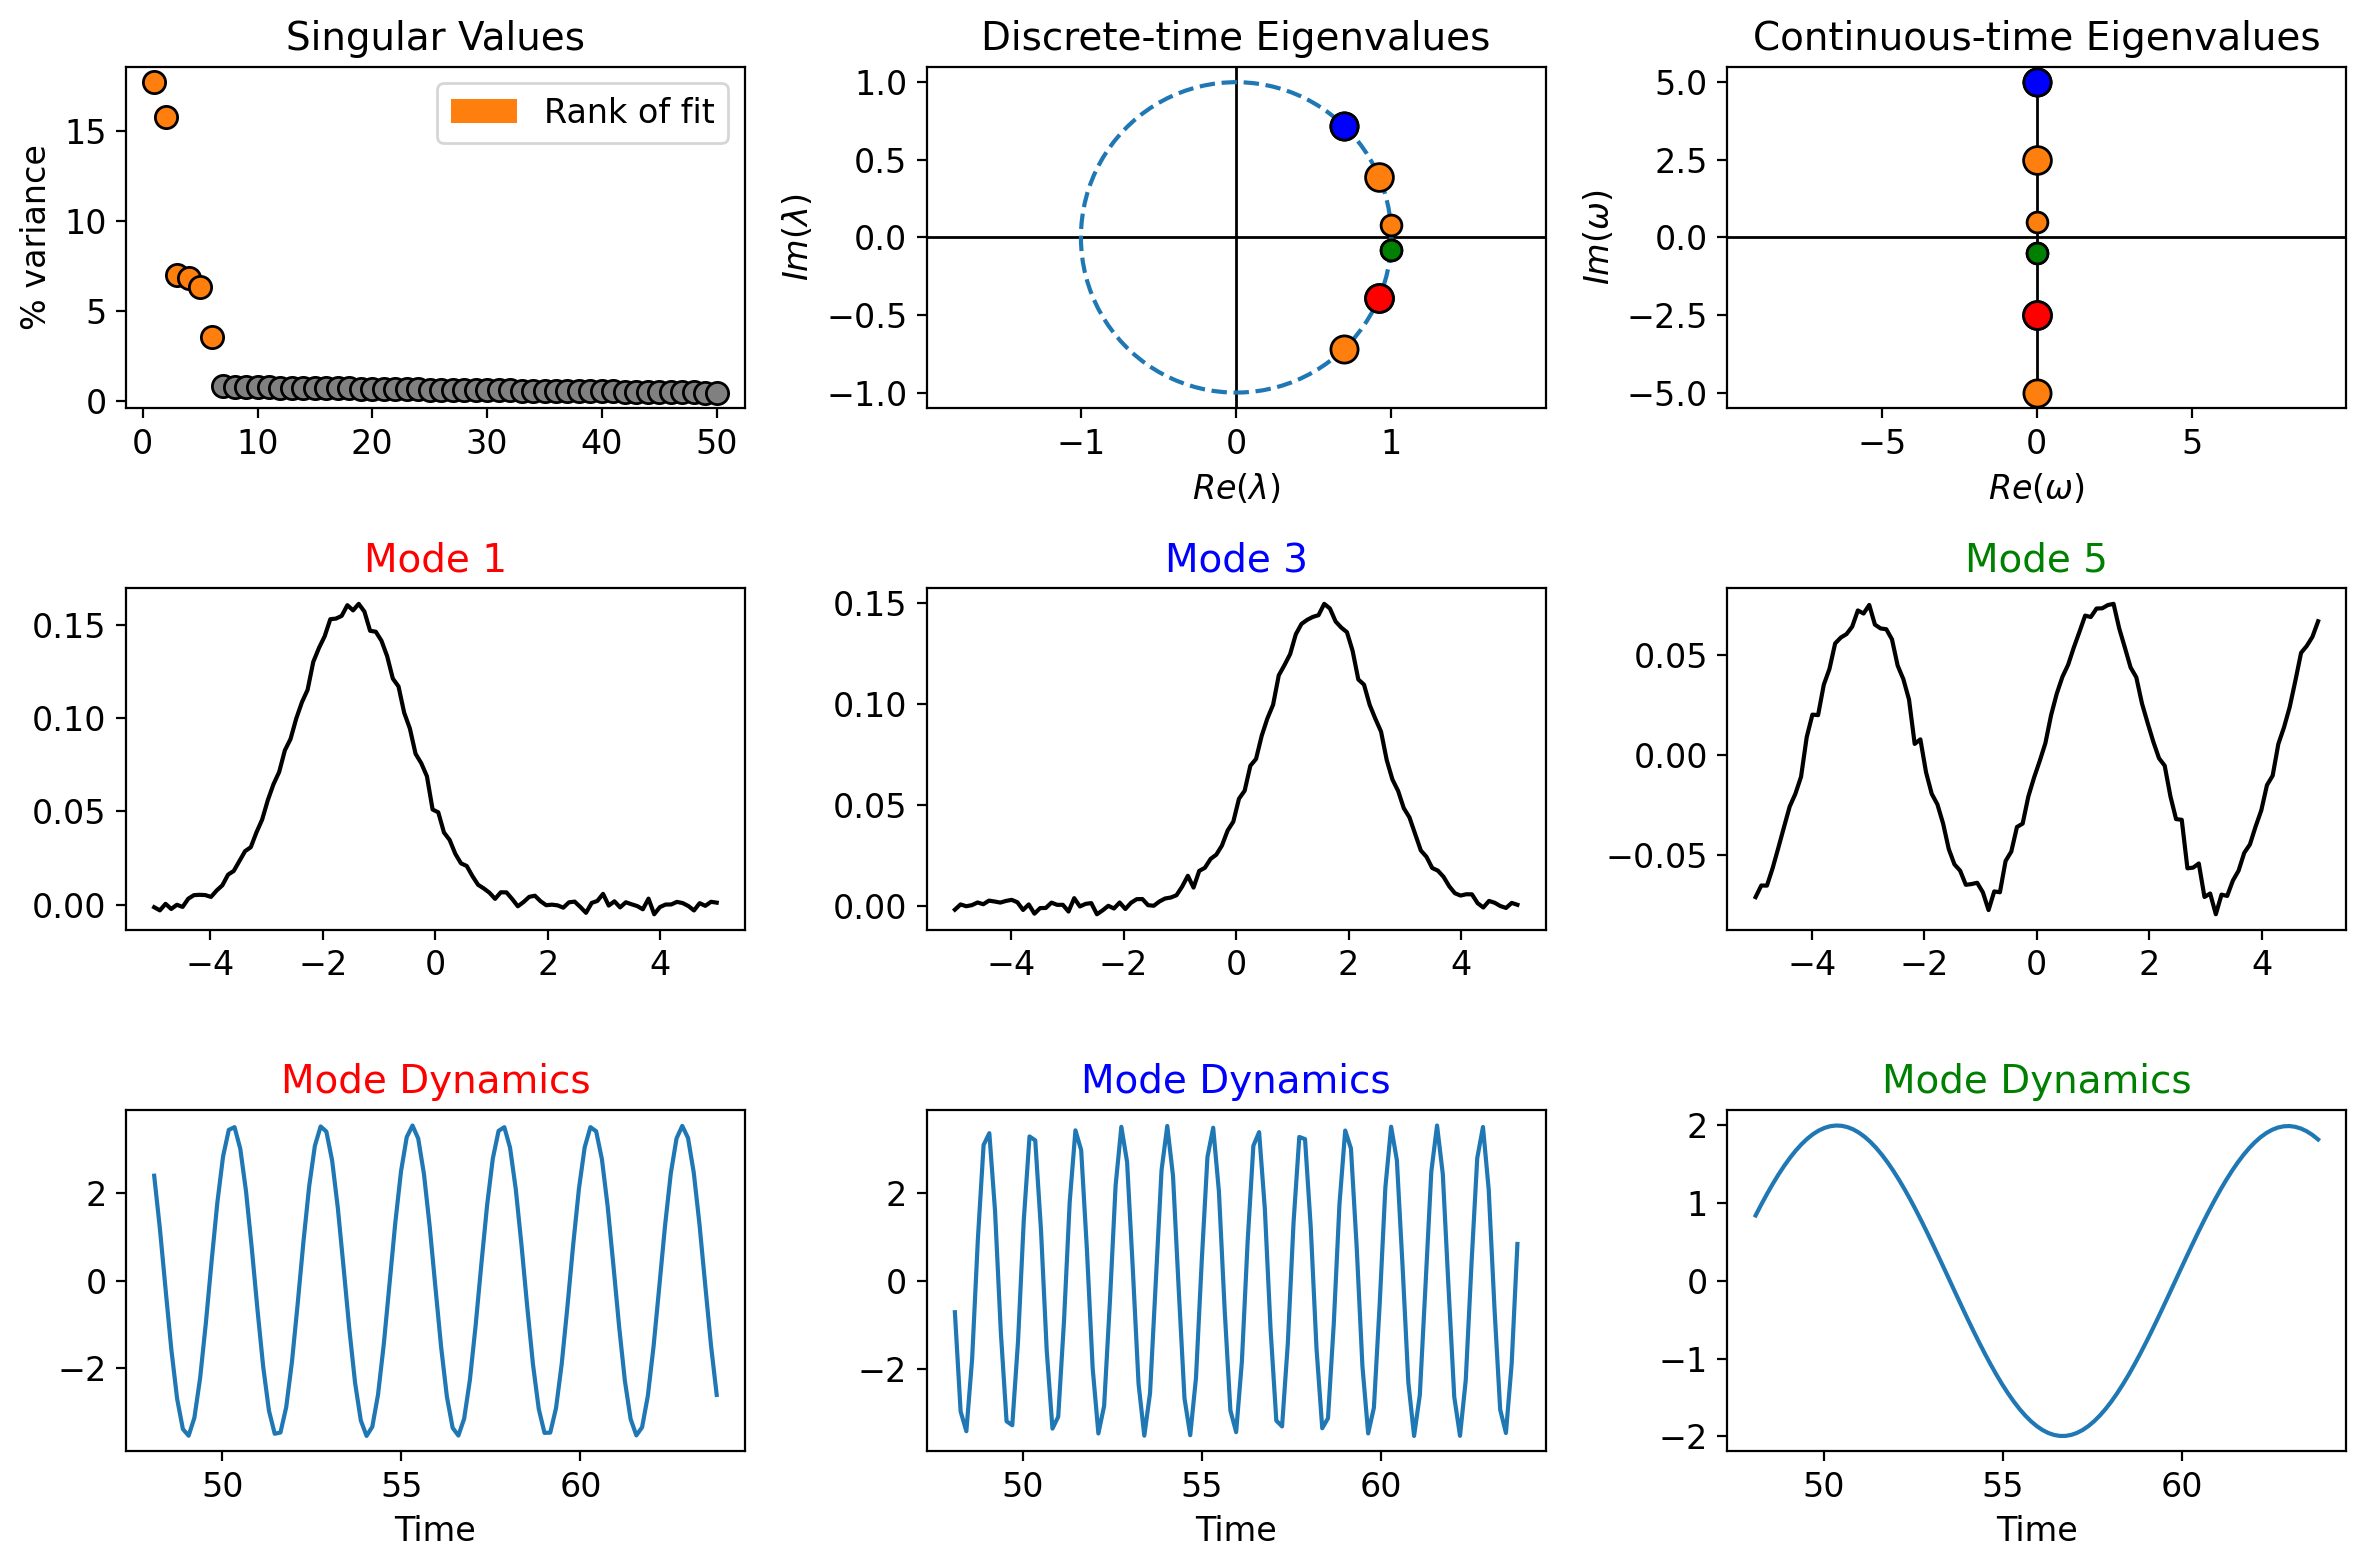

In [21]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd_fast, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

Sort the modes by amplitude and print the amplitudes and eigenvalues.

In [22]:
sorted_index_fast = np.argsort(delay_optdmd_fast.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd_fast.amplitudes[sorted_index_fast]}")
print(f"Eigenvalues: {delay_optdmd_fast.eigs[sorted_index_fast]}")

Amplitudes: [3.62271748 3.62271748 3.46933043 3.46933043 2.02522782 2.02522782]
Eigenvalues: [-0.00034142-2.4993736j  -0.00034142+2.4993736j   0.00032363+5.00114696j
  0.00032363-5.00114696j -0.00027137-0.49892448j -0.00027137+0.49892448j]


## Construct the combined DMD model
Here we will cherry-pick the modes of interest from each of the three DMD models to construct a combined model.

In [23]:
def make_forecast(modes, amps, eigs, t):
    """
    Make forecast over time t from DMD modes,
    amplitudes, and eigenvalues.
    """
    forecast = np.linalg.multi_dot(
            [
                modes,
                np.diag(amps),
                np.exp(np.outer(eigs, t)),
            ]
        )
    return forecast

Cherry-pick the modes from each DMD model:
- From the DMD model on the slow-rate data, we take the slowest mode(s) (the last two modes in this case)
- From the DMD model on the medium-rate data, we take the medium-speed mode(s) (the third and fourth modes in this case)
- From the DMD model on the fast-rate data, we take the fastest mode(s) (the third and fourth modes in this case)

In [24]:
# slow
modes = delay_optdmd_slow.modes[:, sorted_index_slow[-2:]]
amps = delay_optdmd_slow.amplitudes[sorted_index_slow[-2:]]
eigs = delay_optdmd_slow.eigs[sorted_index_slow[-2:]]

# medium
modes = np.column_stack((modes, delay_optdmd_medium.modes[:, sorted_index_medium[2:4]]))
amps = np.append(amps, delay_optdmd_medium.amplitudes[sorted_index_medium[2:4]])
eigs = np.append(eigs, delay_optdmd_medium.eigs[sorted_index_medium[2:4]])

# fast
modes = np.column_stack((modes, delay_optdmd_fast.modes[:, sorted_index_fast[2:4]]))
amps = np.append(amps, delay_optdmd_fast.amplitudes[sorted_index_fast[2:4]])
eigs = np.append(eigs, delay_optdmd_fast.eigs[sorted_index_fast[2:4]])


Now make the forecast using the combined model.

In [25]:
forecast = make_forecast(modes, amps, eigs, t_test)  # forecast over the test time period
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

Compare the forecast to the ground truth.

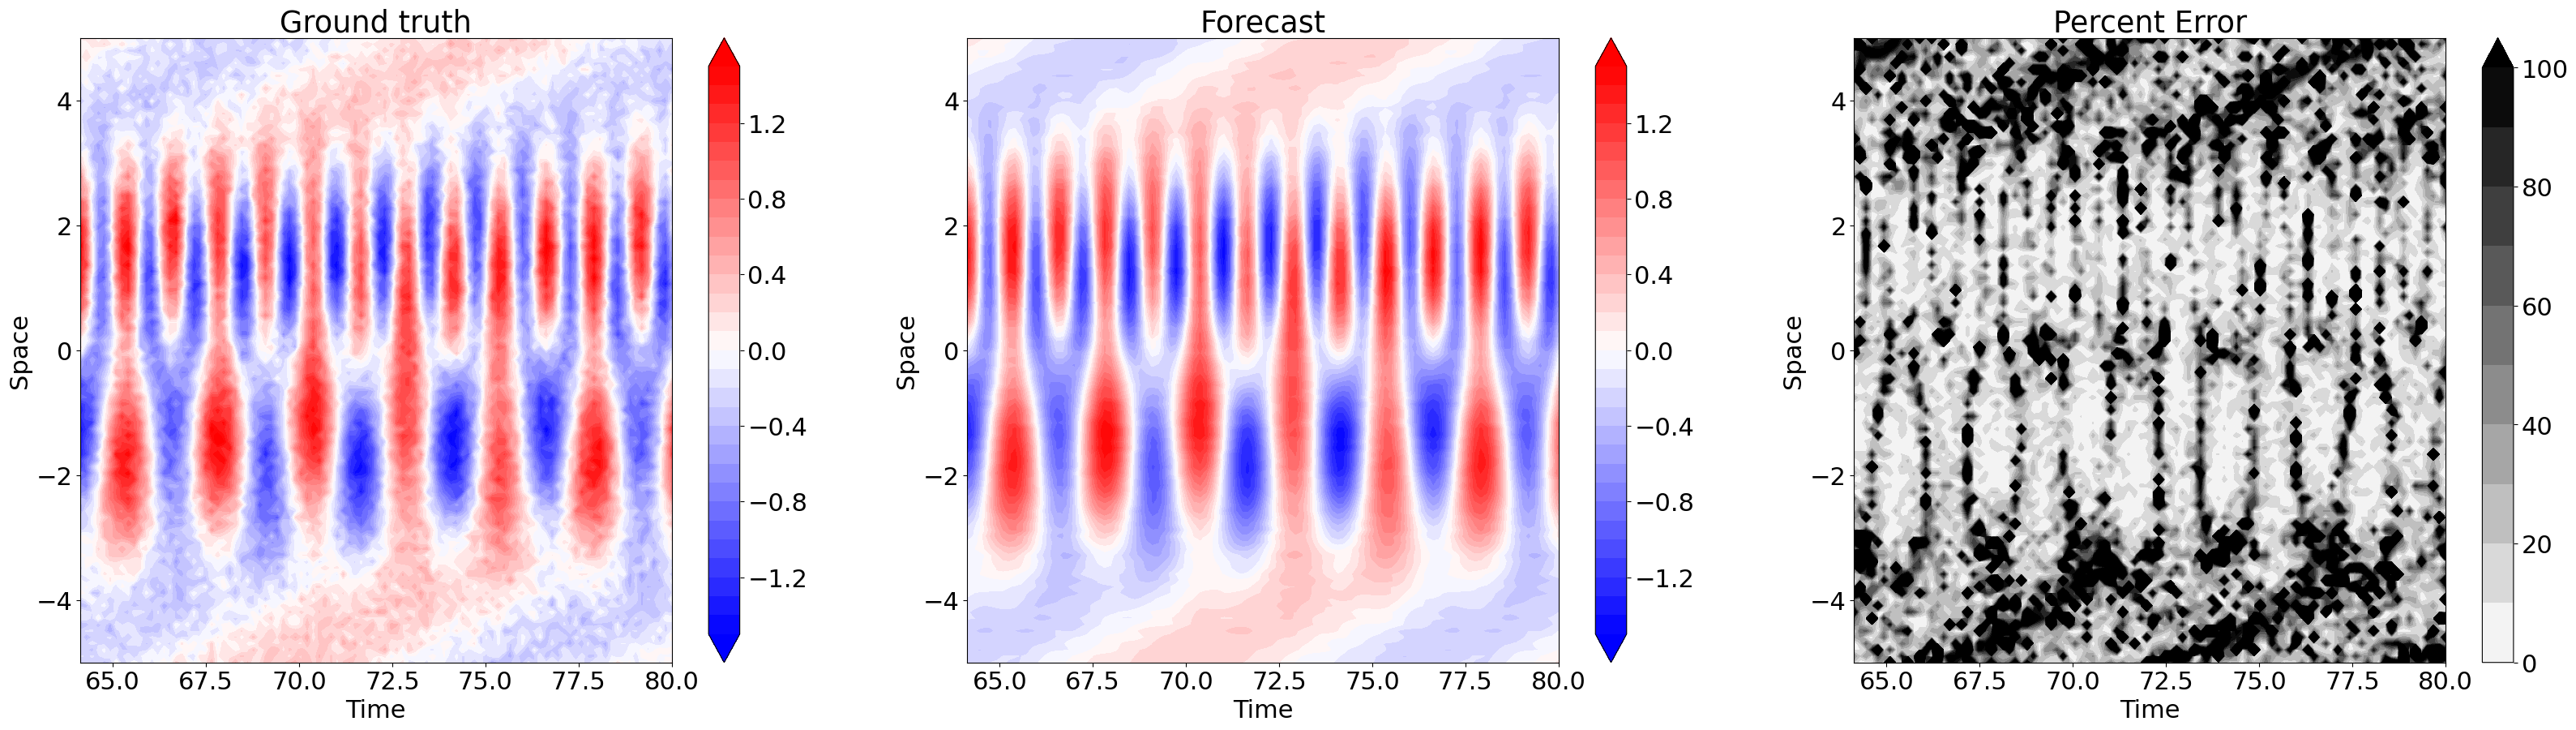

In [26]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, signal_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(signal_test - forecast) / np.abs(signal_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Conclusion

We have shown that we can apply separate DMD models to subsamples of a dataset, and then combine the results to get an accurate forecast. This is useful when the dataset you want to apply DMD to is too large to fit into memory all at once.